Tutorial 4 (Image embeddings for Classification)
======================


## About

For this part of the assignment is dedicated to different image embeddings (DINO, CLIP, ResNet).


<hr>

* The <b><font color="red">red</font></b> color indicates the task that should be done, like <b><font color="red">[TODO]</font></b>: ...
* Addicitional comments, hints are in <b><font color="blue">blue</font></b>. For example <b><font color="blue">[HINT]</font></b>: ...

## Prelimiaries

In [2]:
!pip install datasets
!pip install fiftyone
!pip install scikit-learn
!pip install tensorboard jupyter-tensorboard
!pip install tqdm

In [3]:
import os
import gdown
import zipfile
from tqdm import tqdm
from copy import deepcopy
import json
import time
import pandas as pd
from datetime import datetime

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms


from datasets import load_dataset
from datasets import Dataset, DatasetDict

from transformers import AutoImageProcessor, AutoModel

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

In [4]:
# make plots a bit nicer
plt.matplotlib.rcParams.update({'font.size': 18, 'font.family': 'serif'})

## Auxilary functions

### Training related

We will reuse the scripts from previous tutorials. It is a bit reduntant, but all notebooks are self-contained.

In [5]:
def train_and_validate(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    num_epoch: int,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    device: torch.device,
    max_iter: int | None = None
) -> nn.Module:
    """Simple training script."""

    model.to(device)

    best_val_accuracy = 0.0
    best_model_state = None

    for epoch in range(num_epoch):
        model.train()
        train_metrics = {"loss": 0.0, "correct": 0, "amount": 0}

        for batch_idx, (inputs, labels) in tqdm(enumerate(train_loader), 'training', total=len(train_loader)):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(output, 1)
            train_metrics["amount"] += inputs.size(0)
            train_metrics["loss"] += loss.item() * inputs.size(0)
            train_metrics["correct"] += torch.sum(preds == labels.data)

            if max_iter and batch_idx > max_iter:
                break

        train_loss = train_metrics["loss"] / len(train_loader.dataset)
        train_acc = train_metrics["correct"].float() / len(train_loader.dataset)

        model.eval()
        val_metrics = {"loss": 0.0, "correct": 0}
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, 'evaluation', total=len(val_loader)):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                val_metrics["loss"] += loss.item() * inputs.size(0)
                val_metrics["correct"] += torch.sum(preds == labels.data)

        val_loss = val_metrics["loss"] / len(val_loader.dataset)
        val_acc = val_metrics["correct"].float() / len(val_loader.dataset)

        if val_acc > best_val_accuracy:
            best_model_state = deepcopy(model.state_dict())
            best_val_accuracy = val_acc

        print(
            f'Epoch [{epoch + 1}/{num_epoch}], '
            f'train loss: {train_loss:.4f}, train acc: {train_acc:.4f}, '
            f'val loss: {val_loss:.4f}, val acc: {val_acc:.4f}'
        )

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model

In [6]:
def predict(
    model: nn.Module,
    data_loader: torch.utils.data.DataLoader,
    device: torch.device,
) -> np.ndarray:
    """ Predict on a given dataloader. """
    model.to(device)
    model.eval()
    predictations = []
    ground_truth_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictations.extend(preds.cpu().numpy())
            ground_truth_labels.extend(labels)
    return np.array(predictations), np.array(ground_truth_labels)

### Models related

In [6]:
class SimpleMLP(nn.Module):

    def __init__(self, input_size: int, hidden_size: int, n_classes: int):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, n_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Data related

In [7]:
def create_hf_cocoo_dataset(path_coco_o: str, path_data: str, seed: int = 42, test_ratio = 0.3) -> tuple[DatasetDict, list[str]]:
    def load_image(example):
        example['image'] = Image.open(example['image_path'])
        return example

    if not os.path.exists(path_coco_o):
        url = 'https://drive.google.com/uc?id=1aBfIJN0zo_i80Hv4p7Ch7M8pRzO37qbq'
        zip_file_path = os.path.join(path_data, 'ood_coco.zip')
        gdown.download(url, zip_file_path, quiet=False)
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(path_data)

    cocoo_classes_list = os.listdir(path_coco_o)
    all_elements_coco = [
        (os.path.join(path_coco_o, label, 'val2017', img), index)
        for index, label in enumerate(cocoo_classes_list)
        for img in os.listdir(os.path.join(path_coco_o, label, 'val2017'))
    ]

    np.random.seed(seed)
    indices = np.arange(len(all_elements_coco))
    np.random.shuffle(indices)
    n_test = int(len(indices) * test_ratio)

    train_indices, test_indices = indices[n_test:], indices[:n_test]
    datasets = {}

    for split, split_indices in zip(['train', 'test'], [train_indices, test_indices]):
        split_data = [(all_elements_coco[i][0], all_elements_coco[i][1]) for i in split_indices]
        image_paths, labels = zip(*split_data)
        dataset = Dataset.from_dict({'image_path': image_paths, 'label': labels})
        datasets[split] = dataset.map(load_image, remove_columns=['image_path'])

    return DatasetDict(datasets), cocoo_classes_list

### Embedding related

In [8]:
def extract_embedding(processor, model, image, dino_mode: str = 'clc', device: torch.device = None) -> np.ndarray:
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model_name = model.__class__.__name__.lower()

    with torch.no_grad():
        inputs = processor(images=image, return_tensors='pt').to(device)
        outputs = model(**inputs)

        if 'dino' in model_name:
            image_features = outputs.last_hidden_state
            image_features = (
                image_features.mean(dim=1) if dino_mode == 'mean'
                else image_features[:, 0, :]
                if dino_mode == 'clc'
                else ValueError("Unsupported 'mode': choose 'mean' or 'clc'")
            )
        elif 'clip' in model_name:
            image_features = model.get_image_features(**inputs)
        elif 'resnet' in model_name:
            image_features = outputs.pooler_output
        else:
            raise ValueError("Unknown 'model_type': choose 'dino', 'clip', or 'resnet'")

    return np.float32(image_features.detach().cpu().numpy().squeeze())

In [9]:
def save_embeddings_and_labels(data_set, processor, model, path_data, dataset_name, model_name, parts=['train', 'test']):
    for ds_part in parts:
        fname = f'{dataset_name}_{model_name}_{ds_part}'
        embeddings, labels = zip(*[
            (
                extract_embedding(processor, model, dinfo['image'].convert('RGB') if dinfo['image'].mode != 'RGB' else dinfo['image']),
                dinfo['label']
            )
            for dinfo in tqdm(data_set[ds_part])
        ])

        np.save(os.path.join(path_data, f'{fname}_features.npy'), np.array(embeddings))
        np.save(os.path.join(path_data, f'{fname}_labels.npy'), np.array(labels))

def load_saved_data(path_data, dataset_name, model_name, parts=['train', 'test']):
    def load_part(ds_part):
        fname = f'{dataset_name}_{model_name}_{ds_part}'
        features_path = os.path.join(path_data, f'{fname}_features.npy')
        labels_path = os.path.join(path_data, f'{fname}_labels.npy')
        if os.path.exists(features_path) and os.path.exists(labels_path):
            return np.load(features_path), np.load(labels_path)
        else:
            print(f"Files for {ds_part} not found at {features_path} and/or {labels_path}")
            return None, None

    all_embeddings, all_labels = {}, {}
    for part in parts:
        embeddings, labels = load_part(part)
        if embeddings is not None and labels is not None:
            all_embeddings[part] = embeddings
            all_labels[part] = labels

    return all_embeddings, all_labels

In [10]:
def collate_fn(batch):
    data = torch.stack([torch.tensor(item['data']) for item in batch])
    labels = torch.tensor([item['labels'] for item in batch])
    return data, labels

## Load data

In [12]:
# Set the local folder with the data
path_data = "./data"
os.makedirs(path_data, exist_ok=True)

In [13]:
# Load cifar10 dataset
cifar10_dataset = load_dataset('cifar10', cache_dir=path_data)
cifar10_dataset = cifar10_dataset.rename_column(original_column_name='img', new_column_name='image')
cifar10_classes_list = cifar10_dataset['train'].features['label'].names

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [14]:
# Load DTD dataset
dtd_dataset = load_dataset("tanganke/dtd", cache_dir=path_data)
dtd_classes_list = dtd_dataset['train'].features['label'].names

In [15]:
# Load COCO-O dataset
path_coco_o = os.path.join(path_data, 'ood_coco')
cocoo_dataset, cocoo_classes_list = create_hf_cocoo_dataset(path_coco_o, path_data)

Map:   0%|          | 0/4748 [00:00<?, ? examples/s]

Map:   0%|          | 0/2034 [00:00<?, ? examples/s]

In [16]:
# Define mappings for datasets
datasets = {
    'cocoo': (cocoo_dataset, cocoo_classes_list),
    'cifar10': (cifar10_dataset, cifar10_classes_list),
    'dtd': (dtd_dataset, dtd_classes_list)
}

## Models

In [17]:
models = {
    'dino': ('facebook/dinov2-base', 'facebook/dinov2-base'),
    'clip': ('openai/clip-vit-base-patch32', 'openai/clip-vit-base-patch32'),
    'resnet': ('microsoft/resnet-50', 'microsoft/resnet-50'),
    'dinov3_small': ('facebook/dinov3-vits16-pretrain-lvd1689m',
                     'facebook/dinov3-vits16-pretrain-lvd1689m'),
    'dinov3_base': ('facebook/dinov3-vitb16-pretrain-lvd1689m',
                    'facebook/dinov3-vitb16-pretrain-lvd1689m'),
    'dinov3_large': ('facebook/dinov3-vitl16-pretrain-lvd1689m',
                     'facebook/dinov3-vitl16-pretrain-lvd1689m')
}

## Select dataset (COCO-O) and model (DINO)

In [19]:
# Select dataset
# We will start with 'cocoo' dataset
dataset_name = 'cocoo'  # e.g., 'cocoo', 'cifar10', 'dtd'
data_set, data_classes_list = datasets.get(dataset_name, (None, None))
if data_set is None:
    print('...unknown dataset')

# Select embedding model
# We will start with 'DINOv2' model
model_name = 'dino'  # e.g., 'dino', 'clip', 'resnet'
model_info = models.get(model_name, None)
if model_info:
    processor = AutoImageProcessor.from_pretrained(model_info[0])
    model = AutoModel.from_pretrained(model_info[1])
else:
    print('...unknown model')

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


cartoon


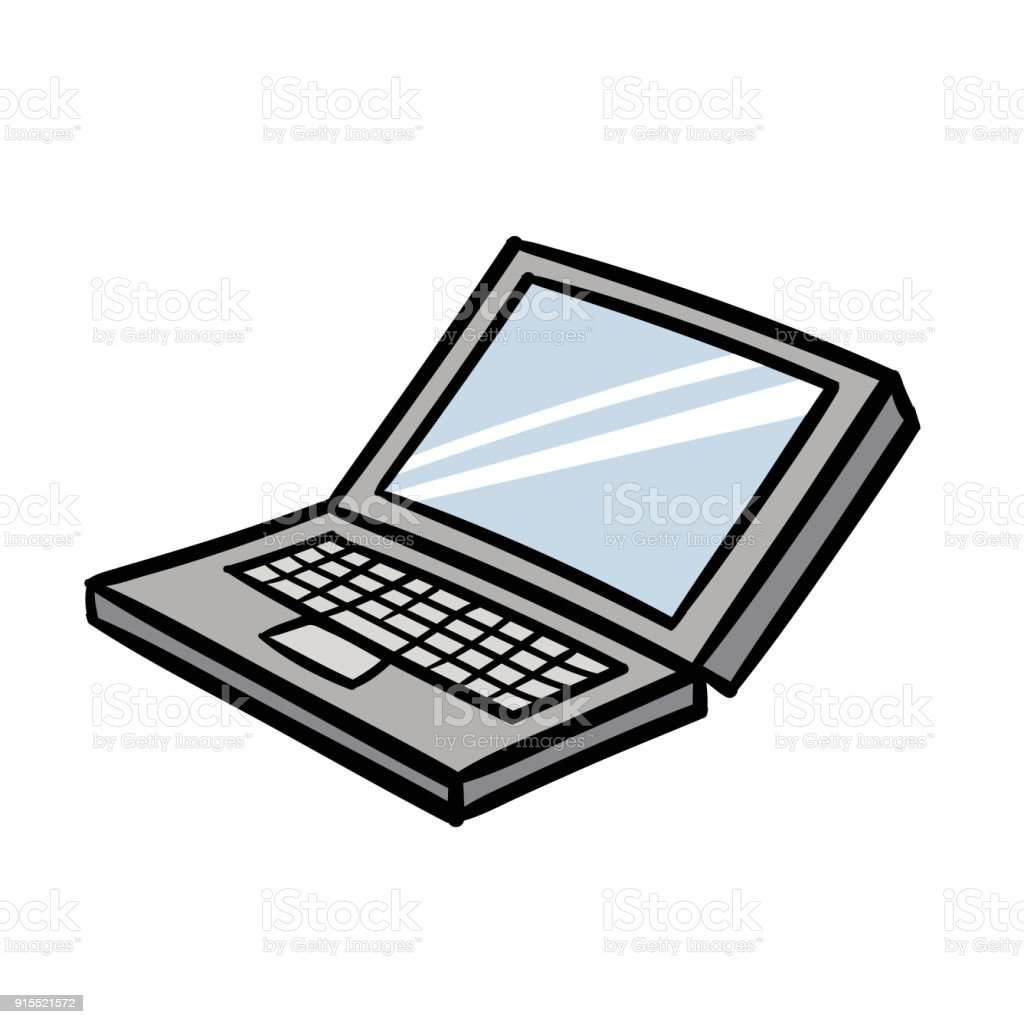

In [20]:
# Inspect one image
img = data_set['train'][0]['image']
label = data_set['train'][0]['label']
print(data_classes_list[label])
img

## Generate embeddings

In [21]:
# Run one image and check
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval() # adding this to avoid runtime error bc of device mismatch
img_features = extract_embedding(processor, model, img, device=device)
print(img_features.shape)

(768,)


In [23]:
# To run on whole dataset and save embeddings
# We can do it for different folders and different datasets
save_embeddings_and_labels(data_set, processor, model, path_data, dataset_name, model_name)

 16%|█▋        | 781/4748 [00:31<02:15, 29.35it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 2034/2034 [01:12<00:00, 28.15it/s]


In [24]:
# Once saved, we load one specific embeddings
model_name = 'dino'
dataset_name = 'cocoo'
embeddings_preloaded, labels_preloaded = load_saved_data(path_data, dataset_name, model_name)

## Training classifier

In [25]:
# Dataloaders for training
dataset_train = Dataset.from_dict({'data': embeddings_preloaded['train'], 'labels': labels_preloaded['train']})
dataset_test = Dataset.from_dict({'data': embeddings_preloaded['test'], 'labels': labels_preloaded['test']})
trainloader = DataLoader(dataset_train, batch_size=32, shuffle=False, collate_fn=collate_fn)
testloader = DataLoader(dataset_test, batch_size=32, shuffle=True, collate_fn=collate_fn)

In [26]:
# Set the device
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

In [ ]:
# Set criterion
criterion = nn.CrossEntropyLoss()

In [ ]:
# Other learning settings
num_epoch = 10
learning_rate = 0.001
batch_size = 64

In [ ]:
# Let's have a look at the sizes of the loaders
print(len(trainloader))
print(len(testloader))

# Let's check sizes of the batch and their types
images, labels = next(iter(testloader))
print(images.shape, type(images))
print(labels.shape, type(labels))

149
64
torch.Size([32, 768]) <class 'torch.Tensor'>
torch.Size([32]) <class 'torch.Tensor'>


In [ ]:
# Set-up model and optimizer
model_mlp = SimpleMLP(768, 128, 47)
optimizer = torch.optim.Adam(model_mlp.parameters(), lr=learning_rate)

In [ ]:
# Let's train!

In [ ]:
%%time
best_model = train_and_validate(
    model=model_mlp,
    train_loader=trainloader,
    val_loader=testloader,
    num_epoch=num_epoch,
    criterion=criterion,
    optimizer=optimizer,
    device=device
)

evaluation: 100%|██████████| 64/64 [00:00<00:00, 67.28it/s]


Epoch [1/10], train loss: 0.4800, train acc: 0.8675, val loss: 0.2237, val acc: 0.9228


evaluation: 100%|██████████| 64/64 [00:00<00:00, 67.05it/s]


Epoch [2/10], train loss: 0.1286, train acc: 0.9543, val loss: 0.2708, val acc: 0.9130


evaluation: 100%|██████████| 64/64 [00:00<00:00, 67.48it/s]


Epoch [3/10], train loss: 0.0870, train acc: 0.9709, val loss: 0.2149, val acc: 0.9277


evaluation: 100%|██████████| 64/64 [00:00<00:00, 67.14it/s]


Epoch [4/10], train loss: 0.0581, train acc: 0.9813, val loss: 0.2382, val acc: 0.9228


evaluation: 100%|██████████| 64/64 [00:00<00:00, 68.07it/s]


Epoch [5/10], train loss: 0.0412, train acc: 0.9874, val loss: 0.2710, val acc: 0.9204


evaluation: 100%|██████████| 64/64 [00:01<00:00, 43.06it/s]


Epoch [6/10], train loss: 0.0429, train acc: 0.9842, val loss: 0.3009, val acc: 0.9194


evaluation: 100%|██████████| 64/64 [00:00<00:00, 68.55it/s]


Epoch [7/10], train loss: 0.0295, train acc: 0.9905, val loss: 0.2964, val acc: 0.9326


evaluation: 100%|██████████| 64/64 [00:00<00:00, 68.75it/s]


Epoch [8/10], train loss: 0.0152, train acc: 0.9954, val loss: 0.4329, val acc: 0.9135


evaluation: 100%|██████████| 64/64 [00:01<00:00, 60.55it/s]


Epoch [9/10], train loss: 0.0172, train acc: 0.9952, val loss: 0.5314, val acc: 0.9007


evaluation: 100%|██████████| 64/64 [00:00<00:00, 67.28it/s]

Epoch [10/10], train loss: 0.0195, train acc: 0.9939, val loss: 0.3494, val acc: 0.9292
CPU times: user 35.6 s, sys: 252 ms, total: 35.9 s
Wall time: 36.6 s


In [ ]:
# Let's do another round of training (with smaller LR)
learning_rate = 0.0001
optimizer = torch.optim.Adam(model_mlp.parameters(), lr=learning_rate)
best_model = train_and_validate(
    model=model_mlp,
    train_loader=trainloader,
    val_loader=testloader,
    num_epoch=num_epoch,
    criterion=criterion,
    optimizer=optimizer,
    device=device
)

evaluation: 100%|██████████| 64/64 [00:01<00:00, 35.76it/s]


Epoch [1/10], train loss: 0.0118, train acc: 0.9966, val loss: 0.3006, val acc: 0.9356


evaluation: 100%|██████████| 64/64 [00:01<00:00, 33.50it/s]


Epoch [2/10], train loss: 0.0061, train acc: 0.9983, val loss: 0.3067, val acc: 0.9366


evaluation: 100%|██████████| 64/64 [00:01<00:00, 33.65it/s]


Epoch [3/10], train loss: 0.0040, train acc: 0.9992, val loss: 0.3129, val acc: 0.9361


evaluation: 100%|██████████| 64/64 [00:01<00:00, 32.21it/s]


Epoch [4/10], train loss: 0.0028, train acc: 0.9992, val loss: 0.3224, val acc: 0.9361


evaluation: 100%|██████████| 64/64 [00:02<00:00, 28.71it/s]


Epoch [5/10], train loss: 0.0021, train acc: 0.9994, val loss: 0.3320, val acc: 0.9371


evaluation: 100%|██████████| 64/64 [00:00<00:00, 68.00it/s]


Epoch [6/10], train loss: 0.0016, train acc: 0.9994, val loss: 0.3427, val acc: 0.9361


evaluation: 100%|██████████| 64/64 [00:00<00:00, 67.74it/s]


Epoch [7/10], train loss: 0.0013, train acc: 0.9994, val loss: 0.3522, val acc: 0.9371


evaluation: 100%|██████████| 64/64 [00:00<00:00, 68.39it/s]


Epoch [8/10], train loss: 0.0011, train acc: 0.9996, val loss: 0.3607, val acc: 0.9366


evaluation: 100%|██████████| 64/64 [00:00<00:00, 68.72it/s]


Epoch [9/10], train loss: 0.0010, train acc: 0.9996, val loss: 0.3687, val acc: 0.9376


evaluation: 100%|██████████| 64/64 [00:00<00:00, 64.04it/s]

Epoch [10/10], train loss: 0.0009, train acc: 0.9996, val loss: 0.3766, val acc: 0.9371


In [ ]:
# Make predictations
predictations, true_labels = predict(model=best_model, data_loader=testloader, device=device)

In [ ]:
# Detailed analysis (report)
print(classification_report(true_labels, predictations, target_names=data_classes_list))

              precision    recall  f1-score   support

    handmake       0.98      0.97      0.98       300
     weather       0.98      0.96      0.97       312
     cartoon       0.91      0.94      0.92       579
    painting       0.91      0.91      0.91       266
      tattoo       1.00      1.00      1.00       278
      sketch       0.86      0.85      0.85       299

    accuracy                           0.94      2034
   macro avg       0.94      0.94      0.94      2034
weighted avg       0.94      0.94      0.94      2034



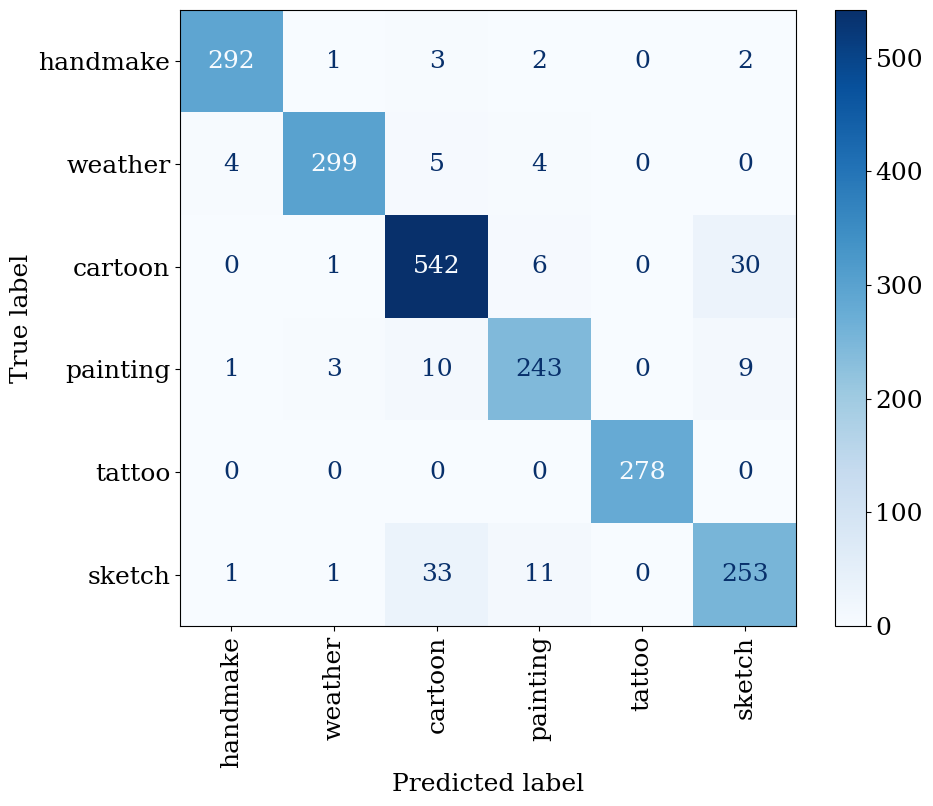

In [ ]:
# Detailed analysis (confusion matrix)

cm = confusion_matrix(true_labels, predictations)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data_classes_list)

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(cmap='Blues', ax=ax, xticks_rotation=90);

### Another embedding

<b><font color="red">[TODO]</font></b>: For the same dataset apply [DINOv3](https://huggingface.co/docs/transformers/main/en/model_doc/dinov3) embeddings model. Compare the result.

**Note**: You will need to register with Hugging Face (if you have not done so already) and accept the terms and conditions for using the DINOv3 models. This should not take much effort or time.

In [27]:
from huggingface_hub import login
login()

In [ ]:
dataset_name = 'cocoo'
data_set, data_classes_list = datasets.get(dataset_name, (None, None))

model_name = 'dinov3_base'

model_info = models.get(model_name, None)

processor_v3 = AutoImageProcessor.from_pretrained(model_info[0])
model_v3 = AutoModel.from_pretrained(model_info[1])

preprocessor_config.json:   0%|          | 0.00/585 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/744 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_v3 = model_v3.to(device)
model_v3.eval()

DINOv3ViTModel(
  (embeddings): DINOv3ViTEmbeddings(
    (patch_embeddings): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (rope_embeddings): DINOv3ViTRopePositionEmbedding()
  (layer): ModuleList(
    (0-11): 12 x DINOv3ViTLayer(
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attention): DINOv3ViTAttention(
        (k_proj): Linear(in_features=768, out_features=768, bias=False)
        (v_proj): Linear(in_features=768, out_features=768, bias=True)
        (q_proj): Linear(in_features=768, out_features=768, bias=True)
        (o_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (layer_scale1): DINOv3ViTLayerScale()
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): DINOv3ViTMLP(
        (up_proj): Linear(in_features=768, out_features=3072, bias=True)
        (down_proj): Linear(in_features=3072, out_features=768, bias=True)
        (act_fn): GELUActivation()
 

In [ ]:
img_features_v3 = extract_embedding(processor_v3, model_v3, img, device=device)

In [ ]:
save_embeddings_and_labels(
    data_set,
    processor_v3,
    model_v3,
    path_data,
    dataset_name,
    model_name
)

 24%|██▍       | 1147/4748 [00:58<03:13, 18.65it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 2034/2034 [02:05<00:00, 16.27it/s]


In [ ]:
embeddings_v3, labels_v3 = load_saved_data(path_data, dataset_name, model_name)

In [ ]:
dataset_train_v3 = Dataset.from_dict({
    'data': embeddings_v3['train'],
    'labels': labels_v3['train']
})
dataset_test_v3 = Dataset.from_dict({
    'data': embeddings_v3['test'],
    'labels': labels_v3['test']
})

trainloader_v3 = DataLoader(dataset_train_v3, batch_size=32, shuffle=True, collate_fn=collate_fn)
testloader_v3 = DataLoader(dataset_test_v3, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [ ]:
images, labels = next(iter(testloader_v3))

embedding_dim = embeddings_v3['train'].shape[1]
num_classes = len(data_classes_list)

In [ ]:
model_mlp_v3 = SimpleMLP(embedding_dim, 128, num_classes)

In [ ]:
learning_rate = 0.001
num_epoch = 10
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_mlp_v3.parameters(), lr=learning_rate)

In [ ]:
best_model_v3 = train_and_validate(
    model=model_mlp_v3,
    train_loader=trainloader_v3,
    val_loader=testloader_v3,
    num_epoch=num_epoch,
    criterion=criterion,
    optimizer=optimizer,
    device=device
)

evaluation: 100%|██████████| 64/64 [00:00<00:00, 69.80it/s]


Epoch [1/10], train loss: 0.4109, train acc: 0.8574, val loss: 0.1641, val acc: 0.9415


evaluation: 100%|██████████| 64/64 [00:01<00:00, 38.17it/s]


Epoch [2/10], train loss: 0.1007, train acc: 0.9659, val loss: 0.1509, val acc: 0.9469


evaluation: 100%|██████████| 64/64 [00:00<00:00, 68.28it/s]


Epoch [3/10], train loss: 0.0670, train acc: 0.9794, val loss: 0.1664, val acc: 0.9459


evaluation: 100%|██████████| 64/64 [00:00<00:00, 68.71it/s]


Epoch [4/10], train loss: 0.0483, train acc: 0.9844, val loss: 0.1594, val acc: 0.9518


evaluation: 100%|██████████| 64/64 [00:00<00:00, 69.40it/s]


Epoch [5/10], train loss: 0.0320, train acc: 0.9888, val loss: 0.1768, val acc: 0.9523


evaluation: 100%|██████████| 64/64 [00:00<00:00, 68.27it/s]


Epoch [6/10], train loss: 0.0212, train acc: 0.9933, val loss: 0.1951, val acc: 0.9464


evaluation: 100%|██████████| 64/64 [00:00<00:00, 68.99it/s]


Epoch [7/10], train loss: 0.0081, train acc: 0.9979, val loss: 0.2124, val acc: 0.9499


evaluation: 100%|██████████| 64/64 [00:00<00:00, 68.93it/s]


Epoch [8/10], train loss: 0.0043, train acc: 0.9994, val loss: 0.2189, val acc: 0.9508


evaluation: 100%|██████████| 64/64 [00:01<00:00, 51.34it/s]


Epoch [9/10], train loss: 0.0016, train acc: 0.9998, val loss: 0.2396, val acc: 0.9508


evaluation: 100%|██████████| 64/64 [00:01<00:00, 43.43it/s]

Epoch [10/10], train loss: 0.0013, train acc: 0.9996, val loss: 0.2430, val acc: 0.9508


In [ ]:
# lower LR
learning_rate = 0.0001
optimizer = torch.optim.Adam(model_mlp_v3.parameters(), lr=learning_rate)

best_model_v3 = train_and_validate(
    model=model_mlp_v3,
    train_loader=trainloader_v3,
    val_loader=testloader_v3,
    num_epoch=num_epoch,
    criterion=criterion,
    optimizer=optimizer,
    device=device
)

evaluation: 100%|██████████| 64/64 [00:00<00:00, 69.78it/s]


Epoch [1/10], train loss: 0.0132, train acc: 0.9966, val loss: 0.1846, val acc: 0.9528


evaluation: 100%|██████████| 64/64 [00:00<00:00, 67.45it/s]


Epoch [2/10], train loss: 0.0073, train acc: 0.9987, val loss: 0.1931, val acc: 0.9553


evaluation: 100%|██████████| 64/64 [00:01<00:00, 55.67it/s]


Epoch [3/10], train loss: 0.0052, train acc: 0.9994, val loss: 0.1971, val acc: 0.9538


evaluation: 100%|██████████| 64/64 [00:00<00:00, 68.73it/s]


Epoch [4/10], train loss: 0.0038, train acc: 0.9996, val loss: 0.2066, val acc: 0.9538


evaluation: 100%|██████████| 64/64 [00:01<00:00, 34.81it/s]


Epoch [5/10], train loss: 0.0027, train acc: 0.9998, val loss: 0.2139, val acc: 0.9533


evaluation: 100%|██████████| 64/64 [00:03<00:00, 19.42it/s]


Epoch [6/10], train loss: 0.0021, train acc: 0.9998, val loss: 0.2216, val acc: 0.9533


evaluation: 100%|██████████| 64/64 [00:01<00:00, 50.93it/s]


Epoch [7/10], train loss: 0.0018, train acc: 0.9996, val loss: 0.2283, val acc: 0.9533


evaluation: 100%|██████████| 64/64 [00:01<00:00, 50.35it/s]


Epoch [8/10], train loss: 0.0016, train acc: 0.9996, val loss: 0.2336, val acc: 0.9528


evaluation: 100%|██████████| 64/64 [00:00<00:00, 69.09it/s]


Epoch [9/10], train loss: 0.0013, train acc: 0.9998, val loss: 0.2408, val acc: 0.9523


evaluation: 100%|██████████| 64/64 [00:00<00:00, 67.49it/s]

Epoch [10/10], train loss: 0.0012, train acc: 0.9998, val loss: 0.2475, val acc: 0.9513


In [ ]:
predictations_v3, true_labels_v3 = predict(
    model=best_model_v3,
    data_loader=testloader_v3,
    device=device
)

print(f"Predictions shape: {predictations_v3.shape}")
print(f"True labels shape: {true_labels_v3.shape}")

Predictions shape: (2034,)
True labels shape: (2034,)


In [ ]:
# Detailed analysis (report)
print(classification_report(true_labels_v3, predictations_v3, target_names=data_classes_list))

              precision    recall  f1-score   support

    handmake       0.98      0.99      0.99       300
     weather       1.00      0.98      0.99       312
     cartoon       0.92      0.96      0.94       579
    painting       0.93      0.96      0.95       266
      tattoo       0.99      1.00      1.00       278
      sketch       0.93      0.84      0.88       299

    accuracy                           0.96      2034
   macro avg       0.96      0.95      0.96      2034
weighted avg       0.96      0.96      0.95      2034



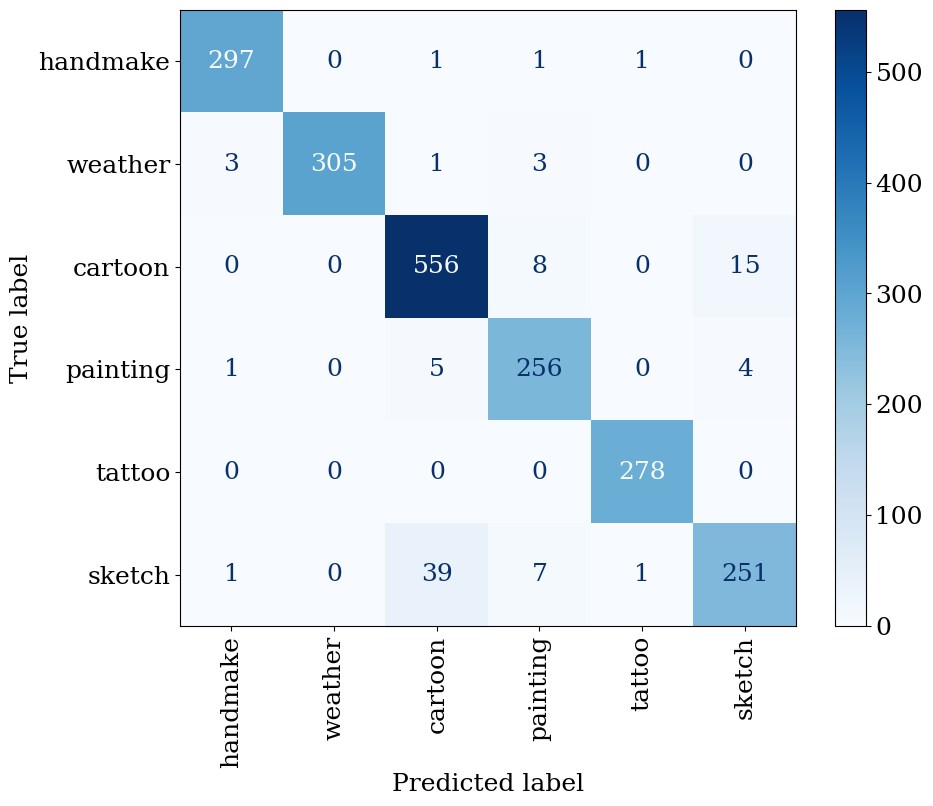

In [ ]:
cm_v3 = confusion_matrix(true_labels_v3, predictations_v3)
disp_v3 = ConfusionMatrixDisplay(confusion_matrix=cm_v3, display_labels=data_classes_list)

fig, ax = plt.subplots(figsize=(10, 8))
disp_v3.plot(cmap='Blues', ax=ax, xticks_rotation=90);

In [ ]:
embeddings_v2, labels_v2 = load_saved_data(path_data, 'cocoo', 'dino')
acc_v3 = accuracy_score(true_labels_v3, predictations_v3)
acc_v2 = accuracy_score(true_labels, predictations)

print(f"\nDINOv3: {acc_v2*100:.2f}%")
print(f"\nDINOv2: {acc_v3*100:.2f}%")


DINOv3: 93.76%

DINOv2: 95.53%


### Another dataset

<b><font color="red">[TODO]</font></b>: Conduct fine-tuning experiments for DTD dataset or cifar10 dataset or both. What is the accuracy, how does it compare to the cnn-based experiments, ViT experiments?

In [ ]:
# using this to do to complete assignment 2 (tech report), for reference

In [28]:
class ExperimentTracker:
    def __init__(self, experiment_name, description):
        self.experiment_name = experiment_name
        self.description = description
        self.start_time = datetime.now()
        self.config = {}
        self.metrics = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': [],
            'epoch_times': []
        }
        self.best_val_acc = 0.0
        self.total_params = 0
        self.trainable_params = 0

    def log_config(self, config_dict):
        self.config.update(config_dict)

    def log_epoch(self, epoch, train_loss, train_acc, val_loss, val_acc, epoch_time):
        self.metrics['train_loss'].append(train_loss)
        self.metrics['train_acc'].append(train_acc)
        self.metrics['val_loss'].append(val_loss)
        self.metrics['val_acc'].append(val_acc)
        self.metrics['epoch_times'].append(epoch_time)
        if val_acc > self.best_val_acc:
            self.best_val_acc = val_acc

    def set_model_info(self, total_params, trainable_params):
        self.total_params = total_params
        self.trainable_params = trainable_params

    def finish(self):
        self.end_time = datetime.now()
        self.total_time = (self.end_time - self.start_time).total_seconds()

    def plot_metrics(self):
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        axes[0].plot(self.metrics['train_loss'], label='Train', marker='o')
        axes[0].plot(self.metrics['val_loss'], label='Val', marker='s')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].set_title(f'{self.experiment_name} - Loss')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        axes[1].plot(self.metrics['train_acc'], label='Train', marker='o')
        axes[1].plot(self.metrics['val_acc'], label='Val', marker='s')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy (%)')
        axes[1].set_title(f'{self.experiment_name} - Accuracy')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        return fig

In [31]:
experiments = {}

In [32]:
class HFDatasetWrapper(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        label = item['label']

        # HuggingFace CIFAR-10 images are already PIL Images
        # Just ensure RGB mode
        if hasattr(image, 'mode') and image.mode != 'RGB':
            image = image.convert('RGB')

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        return image, label

In [33]:
# CIFAR-10 normalization
mean_cifar = [0.4914, 0.4822, 0.4465]
std_cifar = [0.2023, 0.1994, 0.2010]

# ImageNet normalization for DINOv3
mean_imagenet = [0.485, 0.456, 0.406]
std_imagenet = [0.229, 0.224, 0.225]

# Transform functions for CNN (32x32)
def transform_train_cnn(examples):
    transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean_cifar, std_cifar)
    ])
    examples['pixel_values'] = [transform(img.convert('RGB')) for img in examples['image']]
    return examples

def transform_test_cnn(examples):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean_cifar, std_cifar)
    ])
    examples['pixel_values'] = [transform(img.convert('RGB')) for img in examples['image']]
    return examples

# Transform functions for DINOv3 (224x224)
def transform_train_dino(examples):
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.RandomCrop(224, padding=28),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean_imagenet, std_imagenet)
    ])
    examples['pixel_values'] = [transform(img.convert('RGB')) for img in examples['image']]
    return examples

def transform_test_dino(examples):
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean_imagenet, std_imagenet)
    ])
    examples['pixel_values'] = [transform(img.convert('RGB')) for img in examples['image']]
    return examples

In [34]:
cifar10_train_cnn = cifar10_dataset['train'].with_transform(transform_train_cnn)
cifar10_test_cnn = cifar10_dataset['test'].with_transform(transform_test_cnn)

# Custom collate function
def collate_fn(batch):
    pixel_values = torch.stack([item['pixel_values'] for item in batch])
    labels = torch.tensor([item['label'] for item in batch])
    return pixel_values, labels

# Create dataloaders
trainloader_cnn = DataLoader(
    cifar10_train_cnn,
    batch_size=128,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0
)
testloader_cnn = DataLoader(
    cifar10_test_cnn,
    batch_size=128,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=0
)

In [35]:
cifar10_train_dino = cifar10_dataset['train'].with_transform(transform_train_dino)
cifar10_test_dino = cifar10_dataset['test'].with_transform(transform_test_dino)

trainloader_dino = DataLoader(
    cifar10_train_dino,
    batch_size=256,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0
)
testloader_dino = DataLoader(
    cifar10_test_dino,
    batch_size=256,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=0
)


In [36]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

In [37]:
def train_epoch(model, trainloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(trainloader, desc='Training', leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / len(trainloader), 100. * correct / total

In [38]:
def validate(model, testloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc='Validation', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return running_loss / len(testloader), 100. * correct / total

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [40]:
def train_model(model, trainloader, testloader, num_epochs, learning_rate,
                experiment_name, description, device=device):

    tracker = ExperimentTracker(experiment_name, description)


    total_params, trainable_params = count_parameters(model)
    tracker.set_model_info(total_params, trainable_params)
    tracker.log_config({
        'num_epochs': num_epochs,
        'learning_rate': learning_rate,
        'batch_size': trainloader.batch_size,
        'optimizer': 'Adam'
    })

    print(f"\n{'='*70}")
    print(f"Experiment: {experiment_name}")
    print(f"Total params: {total_params:,} | Trainable: {trainable_params:,}")
    print(f"{'='*70}\n")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        epoch_start = time.time()
        train_loss, train_acc = train_epoch(model, trainloader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, testloader, criterion, device)
        epoch_time = time.time() - epoch_start

        tracker.log_epoch(epoch, train_loss, train_acc, val_loss, val_acc, epoch_time)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train: {train_loss:.4f}/{train_acc:.2f}% | "
              f"Val: {val_loss:.4f}/{val_acc:.2f}% | "
              f"Time: {epoch_time:.1f}s")

    tracker.finish()
    print(f"\nBest val acc: {tracker.best_val_acc:.2f}%")
    print(f"Total time: {tracker.total_time/60:.1f} min\n")

    experiments[experiment_name] = tracker
    return model, tracker

In [30]:
class BaselineCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(BaselineCNN, self).__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # Block 2
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # Block 3
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [31]:
# BASELINE CNN
model_baseline = BaselineCNN(num_classes=10).to(device)

model_baseline, exp1 = train_model(
    model=model_baseline,
    trainloader=trainloader_cnn,
    testloader=testloader_cnn,
    num_epochs=5,
    learning_rate=0.001,
    experiment_name="e0001_baseline_cnn",
    description="Baseline CNN trained from scratch on CIFAR-10"
)


Experiment: e0001_baseline_cnn
Total params: 3,249,994 | Trainable: 3,249,994



Epoch [1/5] Train: 1.6361/39.44% | Val: 1.4126/51.26% | Time: 32.7s


Epoch [2/5] Train: 1.1868/57.20% | Val: 0.9635/64.54% | Time: 30.3s


Epoch [3/5] Train: 0.9967/64.80% | Val: 0.9770/66.13% | Time: 30.4s


Epoch [4/5] Train: 0.8839/69.01% | Val: 1.0194/65.84% | Time: 30.2s


Epoch [5/5] Train: 0.7935/72.62% | Val: 0.8041/72.52% | Time: 30.7s

Best val acc: 72.52%
Total time: 2.6 min



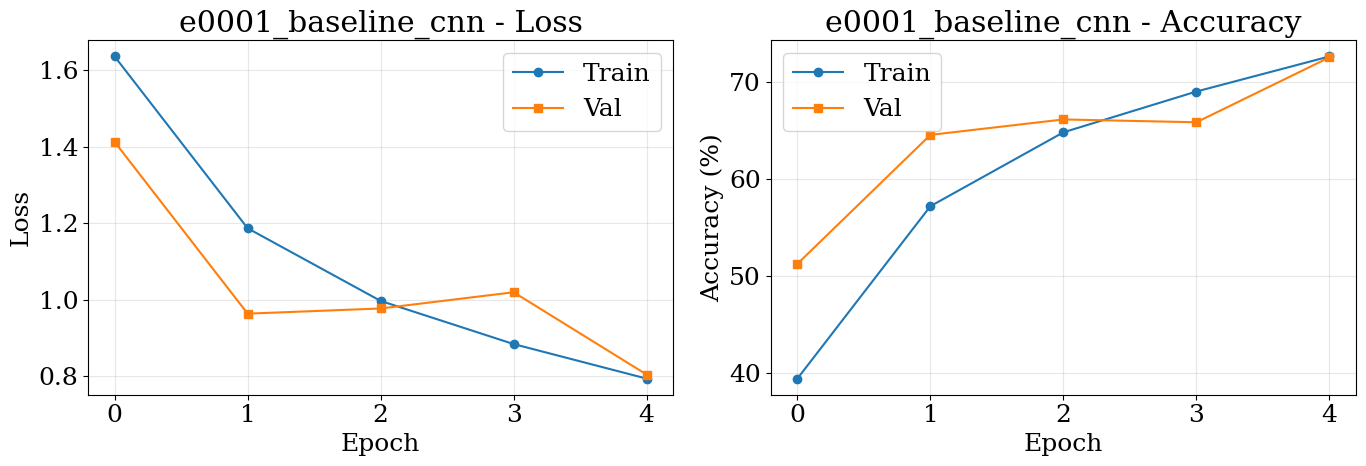

In [32]:
fig = exp1.plot_metrics()
plt.savefig('e0001_baseline_cnn_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

In [33]:
class DINOv3Classifier(nn.Module):
    def __init__(self, dinov3_model, embedding_dim, num_classes, freeze_backbone=True):
        super(DINOv3Classifier, self).__init__()
        self.dinov3 = dinov3_model

        if freeze_backbone:
            for param in self.dinov3.parameters():
                param.requires_grad = False

        self.classifier = nn.Sequential(
            nn.Linear(embedding_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        outputs = self.dinov3(x)
        features = outputs.last_hidden_state[:, 0, :]  # CLS token
        return self.classifier(features)

In [45]:
# BASE
model_name_base = 'facebook/dinov3-vitb16-pretrain-lvd1689m'
dinov3_base = AutoModel.from_pretrained(model_name_base)

In [46]:
with torch.no_grad():
    dummy = torch.rand(1, 3, 224, 224)
    out = dinov3_base(dummy)
    embedding_dim_base = out.last_hidden_state.shape[-1]

In [38]:
model_dinov3_base = DINOv3Classifier(
    dinov3_base, embedding_dim_base, 10, freeze_backbone=True
).to(device)

model_dinov3_base, exp2 = train_model(
    model=model_dinov3_base,
    trainloader=trainloader_dino,
    testloader=testloader_dino,
    num_epochs=5,
    learning_rate=0.001,
    experiment_name="e0002_dinov3_base_frozen",
    description="DINOv3-base with frozen backbone"
)


Experiment: e0002_dinov3_base_frozen
Total params: 86,059,274 | Trainable: 398,858



Epoch [1/5] Train: 0.1456/96.43% | Val: 0.0644/97.94% | Time: 456.8s


Epoch [2/5] Train: 0.0602/98.07% | Val: 0.0641/97.97% | Time: 457.4s


Epoch [3/5] Train: 0.0512/98.23% | Val: 0.0611/97.95% | Time: 457.7s


Epoch [4/5] Train: 0.0439/98.55% | Val: 0.0626/97.81% | Time: 457.3s


Epoch [5/5] Train: 0.0390/98.68% | Val: 0.0615/97.99% | Time: 457.4s

Best val acc: 97.99%
Total time: 38.1 min



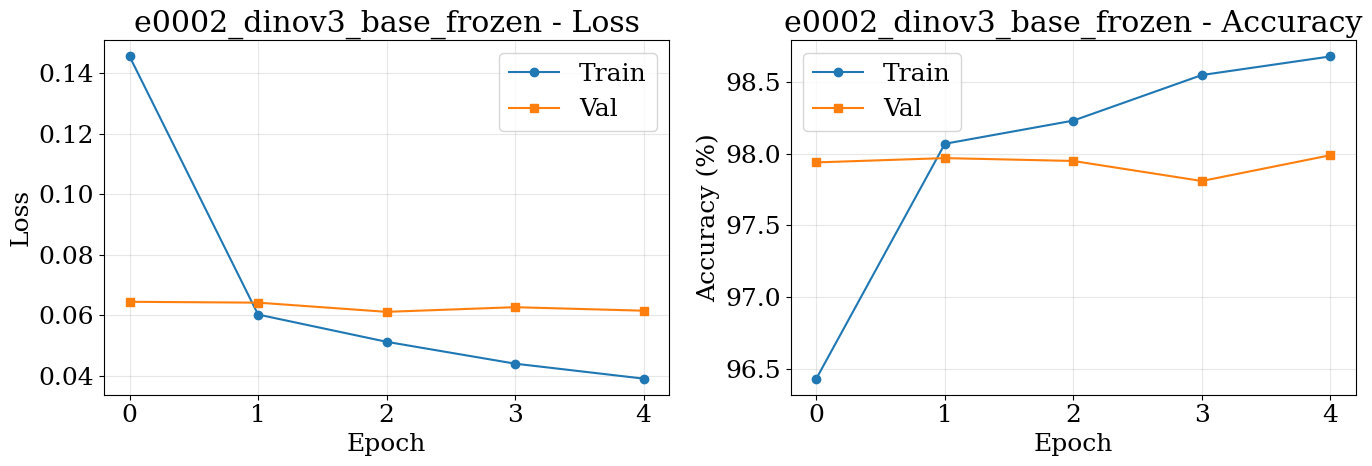

In [39]:
fig = exp2.plot_metrics()
plt.savefig('e0002_dinov3_base_frozen_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

In [42]:
# LARGE
model_name_large = 'facebook/dinov3-vitl16-pretrain-lvd1689m'
dinov3_large = AutoModel.from_pretrained(model_name_large)

In [47]:
with torch.no_grad():
    out = dinov3_large(dummy)
    embedding_dim_large = out.last_hidden_state.shape[-1]

In [42]:
model_dinov3_large = DINOv3Classifier(
    dinov3_large, embedding_dim_large, 10, freeze_backbone=True
).to(device)

model_dinov3_large, exp3 = train_model(
    model=model_dinov3_large,
    trainloader=trainloader_dino,
    testloader=testloader_dino,
    num_epochs=5,
    learning_rate=0.001,
    experiment_name="e0003_dinov3_large_frozen",
    description="DINOv3-large with frozen backbone"
)


Experiment: e0003_dinov3_large_frozen
Total params: 303,659,530 | Trainable: 529,930



Epoch [1/5] Train: 0.0950/98.18% | Val: 0.0362/98.94% | Time: 1248.3s


Epoch [2/5] Train: 0.0246/99.25% | Val: 0.0323/99.07% | Time: 1248.1s


Epoch [3/5] Train: 0.0191/99.37% | Val: 0.0329/99.08% | Time: 1248.1s


Epoch [4/5] Train: 0.0157/99.52% | Val: 0.0343/99.03% | Time: 1248.7s


Epoch [5/5] Train: 0.0138/99.56% | Val: 0.0369/98.95% | Time: 1247.8s

Best val acc: 99.08%
Total time: 104.0 min



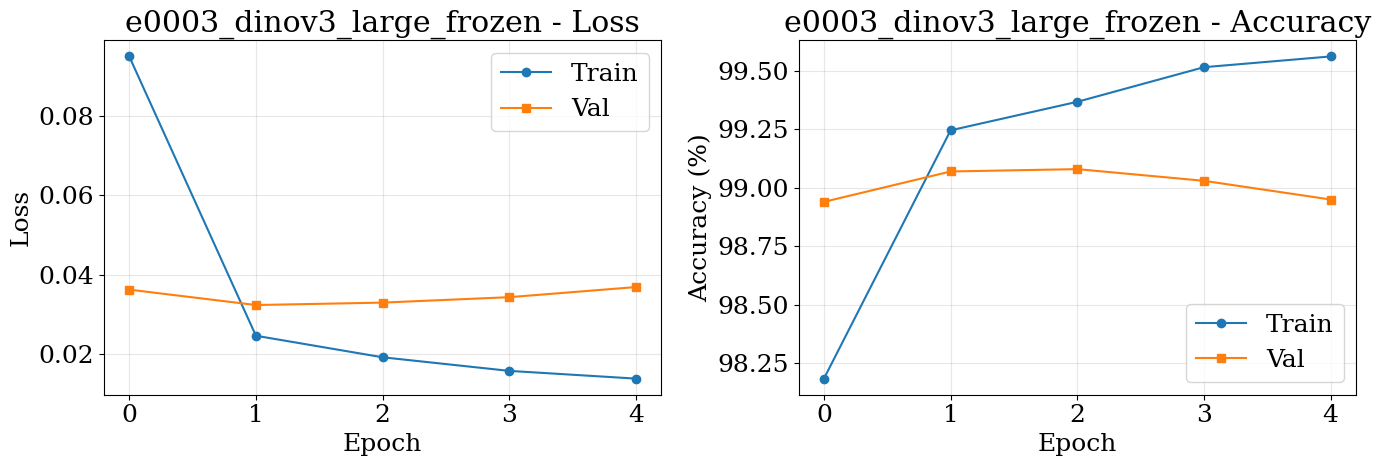

In [43]:
fig = exp3.plot_metrics()
plt.savefig('e0003_dinov3_large_frozen_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

In [44]:
# HEAD ONLY
dinov3_large_ft = AutoModel.from_pretrained(model_name_large)
model_exp4a = DINOv3Classifier(
    dinov3_large_ft, embedding_dim_large, 10, freeze_backbone=True
).to(device)

In [45]:
model_exp4a, exp4a = train_model(
    model=model_exp4a,
    trainloader=trainloader_dino,
    testloader=testloader_dino,
    num_epochs=5,
    learning_rate=0.001,
    experiment_name="e0004a_dinov3_large_head_only",
    description="DINOv3-large - train head only"
)


Experiment: e0004a_dinov3_large_head_only
Total params: 303,659,530 | Trainable: 529,930



Epoch [1/5] Train: 0.0933/98.33% | Val: 0.0347/98.96% | Time: 1249.2s


Epoch [2/5] Train: 0.0243/99.27% | Val: 0.0364/98.95% | Time: 1249.2s


Epoch [3/5] Train: 0.0189/99.40% | Val: 0.0360/98.97% | Time: 1248.6s


Epoch [4/5] Train: 0.0166/99.49% | Val: 0.0389/98.89% | Time: 1248.7s


Epoch [5/5] Train: 0.0131/99.60% | Val: 0.0388/98.91% | Time: 1248.4s

Best val acc: 98.97%
Total time: 104.1 min



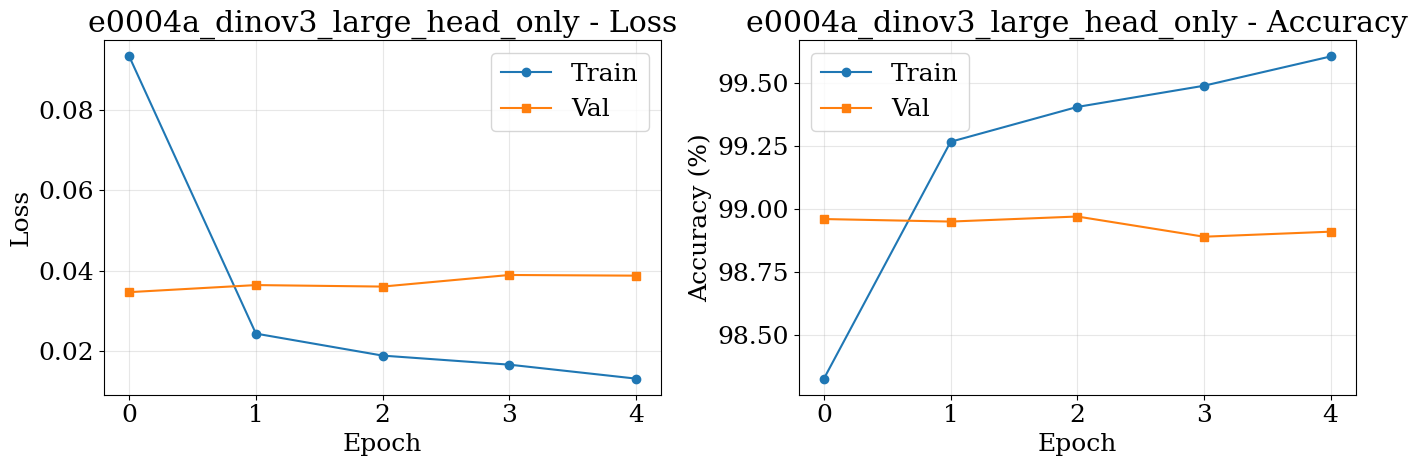

In [46]:
fig = exp4a.plot_metrics()
plt.savefig('e0004a_dinov3_large_head_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

In [53]:
# PARTIAL UNFREEZE
num_layers = len(model_exp4a.dinov3.layer)
for i in range(num_layers - 4, num_layers):
    for param in model_exp4a.dinov3.layer[i].parameters():
        param.requires_grad = True

In [54]:
model_exp4b, exp4b = train_model(
    model=model_exp4a,  # Continue from 4a
    trainloader=trainloader_dino,
    testloader=testloader_dino,
    num_epochs=5,
    learning_rate=0.0001,
    experiment_name="e0004b_dinov3_large_partial_ft",
    description="DINOv3-large - unfreeze last 4 layers"
)


Experiment: e0004b_dinov3_large_partial_ft
Total params: 303,659,530 | Trainable: 50,918,922



Epoch [1/5] Train: 0.0173/99.45% | Val: 0.0350/99.14% | Time: 1503.8s


Epoch [2/5] Train: 0.0087/99.72% | Val: 0.0376/99.24% | Time: 1505.0s


Epoch [3/5] Train: 0.0062/99.81% | Val: 0.0478/99.05% | Time: 1505.0s


Epoch [4/5] Train: 0.0053/99.86% | Val: 0.0398/99.18% | Time: 1504.2s


Epoch [5/5] Train: 0.0032/99.89% | Val: 0.0357/99.32% | Time: 1504.1s

Best val acc: 99.32%
Total time: 125.4 min



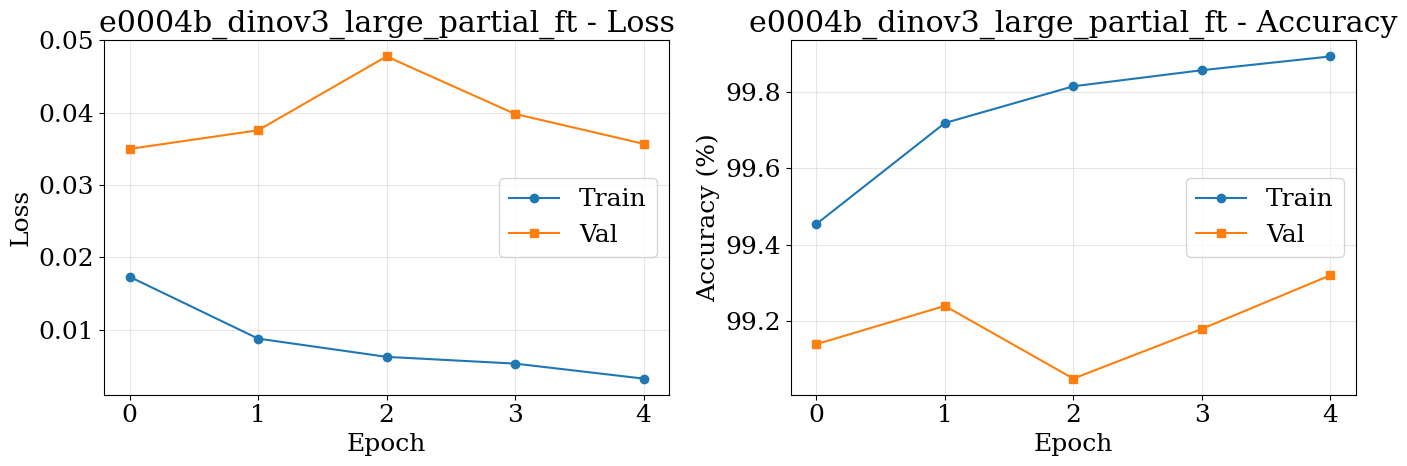

In [55]:
fig = exp4b.plot_metrics()
plt.savefig('e0004b_dinov3_large_partial_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

In [53]:
# ANALYTICS
comparison_data = []
for exp_name, tracker in experiments.items():
    comparison_data.append({
        'Experiment': exp_name,
        'Best Val Acc (%)': f"{tracker.best_val_acc:.2f}",
        'Total Params': f"{tracker.total_params:,}",
        'Trainable Params': f"{tracker.trainable_params:,}",
        'Training Time (min)': f"{tracker.total_time/60:.1f}"
    })

df = pd.DataFrame(comparison_data)
print("\n", df.to_string(index=False))


                     Experiment Best Val Acc (%) Total Params Trainable Params Training Time (min)
            e0001_baseline_cnn            72.52    3,249,994        3,249,994                 2.6
      e0002_dinov3_base_frozen            97.99   86,059,274          398,858                38.1
     e0003_dinov3_large_frozen            99.08  303,659,530          529,930               104.0
 e0004a_dinov3_large_head_only            98.97  303,659,530          529,930               104.1
e0004b_dinov3_large_partial_ft            99.32  303,659,530       50,918,922               125.4


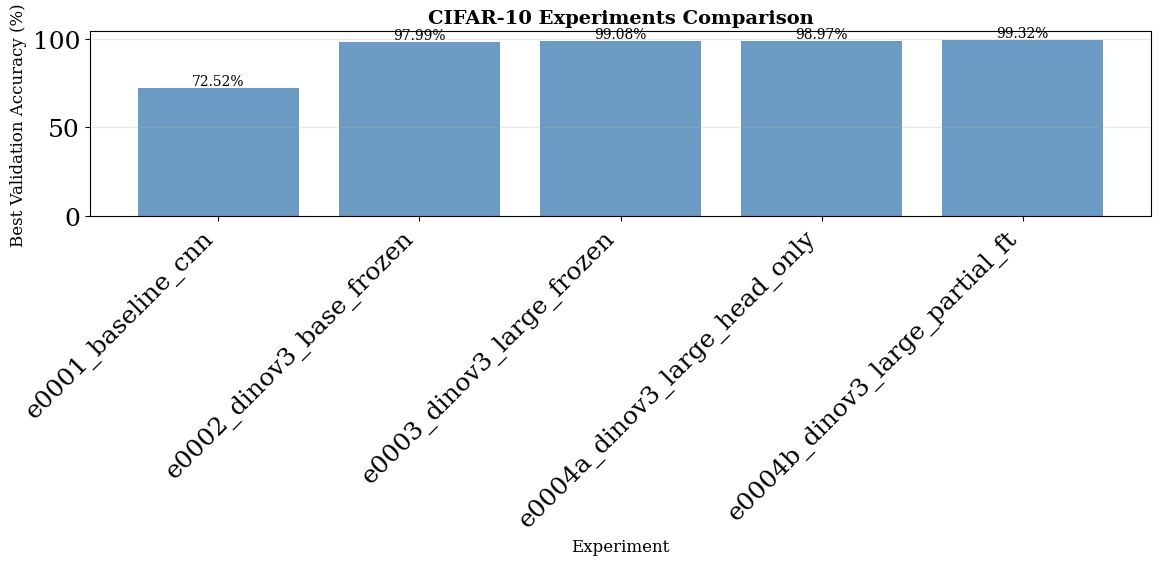

In [54]:
fig, ax = plt.subplots(figsize=(12, 6))
exp_names = [exp['Experiment'] for exp in comparison_data]
accuracies = [float(exp['Best Val Acc (%)']) for exp in comparison_data]

bars = ax.bar(range(len(exp_names)), accuracies, color='steelblue', alpha=0.8)
ax.set_xlabel('Experiment', fontsize=12)
ax.set_ylabel('Best Validation Accuracy (%)', fontsize=12)
ax.set_title('CIFAR-10 Experiments Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(exp_names)))
ax.set_xticklabels(exp_names, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.2f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('experiments_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [55]:
for exp_name, tracker in experiments.items():
    data = {
        'experiment_name': tracker.experiment_name,
        'description': tracker.description,
        'best_val_acc': tracker.best_val_acc,
        'total_params': tracker.total_params,
        'trainable_params': tracker.trainable_params,
        'total_time_minutes': tracker.total_time / 60,
        'config': tracker.config,
        'metrics': tracker.metrics
    }

    with open(f'{exp_name}.json', 'w') as f:
        json.dump(data, f, indent=2)